In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
INVESTMENT = 2000 

TICKERS =['MSFT', 'AAPL', 'GOOG', 'AMZN']

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
stocks_prices = pd.DataFrame({'A' : []})
stocks_info = pd.DataFrame({'A' : []})

for i,ticker in enumerate(TICKERS):
  print(i,ticker)
  yticker = yf.Ticker(ticker)
  
  # Get max history of prices
  historyPrices = yticker.history(period='max')
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date
  
  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)

  # future growth 3 days  
  historyPrices['future_growth_3d'] = historyPrices['Close'].shift(-3) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  if stocks_prices.empty:
    stocks_prices = historyPrices
  else: 
    stocks_prices = pd.concat([stocks_prices,historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 AMZN


In [4]:
# Check one day
filter_last_date = stocks_prices.Date==stocks_prices.Date.max()
print(stocks_prices.Date.max())

2023-05-11


In [5]:
stocks_prices[stocks_prices.Ticker=='AMZN'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,future_growth_3d,volatility
31311,104.269997,105.760002,103.550003,105.660004,56912900,0.0,0.0,AMZN,2023,5,4,2023-05-05,1.015962,1.019589,1.006477,1.070408,1.239414,0.574775,1.042873,44.340004
31312,105.040001,106.099998,104.699997,105.830002,49430900,0.0,0.0,AMZN,2023,5,0,2023-05-08,1.001609,1.021032,0.963668,1.078467,1.274446,0.592459,1.063975,43.018521
31313,105.480003,106.790001,105.160004,106.620003,44089400,0.0,0.0,AMZN,2023,5,1,2023-05-09,1.007465,1.025192,1.011095,1.087515,1.303104,0.595636,NaN,41.637574
31314,108.099998,110.669998,108.050003,110.190002,78541800,0.0,0.0,AMZN,2023,5,2,2023-05-10,1.033483,1.042873,1.079765,1.133176,1.308981,0.615516,NaN,42.286997
31315,111.029999,113.279999,110.489998,112.600502,50812182,0.0,0.0,AMZN,2023,5,3,2023-05-11,1.021876,1.063975,1.086563,1.123197,1.340482,0.642594,NaN,48.284539


In [6]:
df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()
df_pivot.tail(1)

<ipython-input-6-c020f7e1f640>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()


Ticker,Date,AAPL,AMZN,GOOG,MSFT
10692,2023-05-11,173.475006,112.600502,116.985001,309.399994


In [7]:
df_pivot.corr()

<ipython-input-7-197f5de02410>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_pivot.corr()


Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,1.000000,0.934554,0.969350,0.986496
AMZN,0.934554,1.000000,0.954077,0.953729
GOOG,0.969350,0.954077,1.000000,0.979059
MSFT,0.986496,0.953729,0.979059,1.000000


<ipython-input-8-e180225b5b66>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pivot.corr()


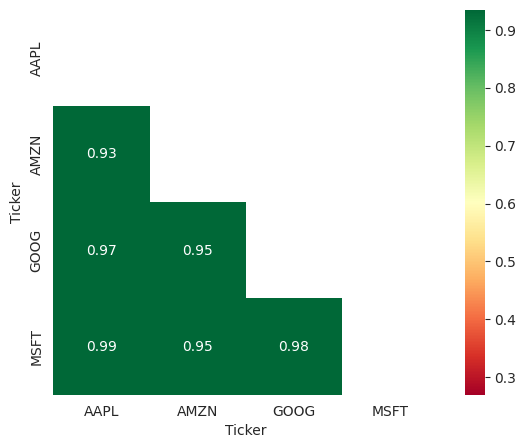

In [8]:
corr = df_pivot.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap='RdYlGn')

In [9]:
df_last_day_prices = stocks_prices[filter_last_date][['Ticker','Close']]
df_last_day_prices

,Ticker,Close
9366,MSFT,309.399994
20059,AAPL,173.475006
24774,GOOG,116.985001
31315,AMZN,112.600502


In [10]:
df_last_day_prices.set_index('Ticker',inplace=True)

In [11]:
df_last_day_prices.sort_values(by='Close', ascending=False)

,Close
Ticker,
MSFT,309.399994
AAPL,173.475006
GOOG,116.985001
AMZN,112.600502


In [12]:
!pip install PyPortfolioOpt

import pypfopt
print(f'\n Library version: {pypfopt.__version__}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 796.0 kB/s eta 0:00:00

 Library version: 1.5.5


In [13]:
from pypfopt import risk_models
from pypfopt import plotting
sample_cov = risk_models.sample_cov(df_pivot.set_index('Date'), frequency=252)
sample_cov

Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,0.200337,0.078985,0.053350,0.063321
AMZN,0.078985,0.327513,0.061153,0.073346
GOOG,0.053350,0.061153,0.095310,0.047892
MSFT,0.063321,0.073346,0.047892,0.114479


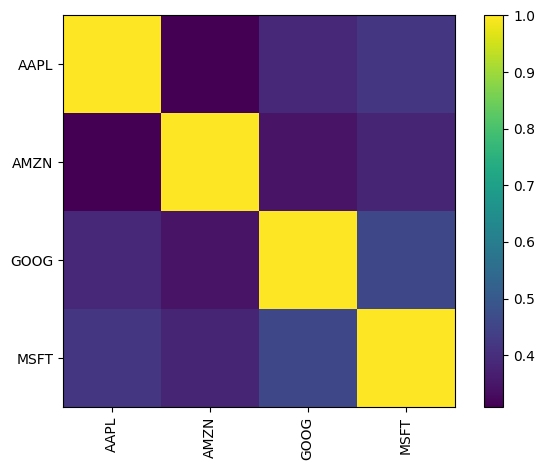

In [14]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

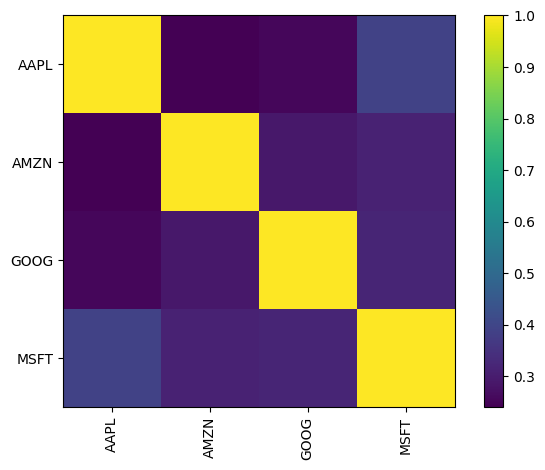

In [15]:
S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

In [16]:
S

Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,0.199915,0.048099,0.023411,0.055138
AMZN,0.048099,0.200072,0.026799,0.044507
GOOG,0.023411,0.026799,0.042661,0.020953
MSFT,0.055138,0.044507,0.020953,0.100528


Expected returns from each stock: Ticker
AAPL    0.259794
AMZN    0.296827
GOOG    0.134929
MSFT    0.173381
Name: mkt, dtype: float64 

Portfolio weights for min volatility optimisation (lowest level of risk): {
    "AAPL": 0.04207,
    "AMZN": 0.03788,
    "GOOG": 0.74266,
    "MSFT": 0.1774
} 

Expected annual return: 15.3%
Annual volatility: 19.3%
Sharpe Ratio: 0.73
Portfolio performance: (0.15313470451807532, 0.19338909358475645, 0.7277282390094851) 

Portfolio weights for max Sharpe optimisation (highest return-per-risk): {
    "AAPL": 0.19139,
    "AMZN": 0.2584,
    "GOOG": 0.43076,
    "MSFT": 0.11945
} 

Expected annual return: 15.3%
Annual volatility: 19.3%
Sharpe Ratio: 0.73
Portfolio performance: (0.15313470451807532, 0.19338909358475645, 0.7277282390094851) 



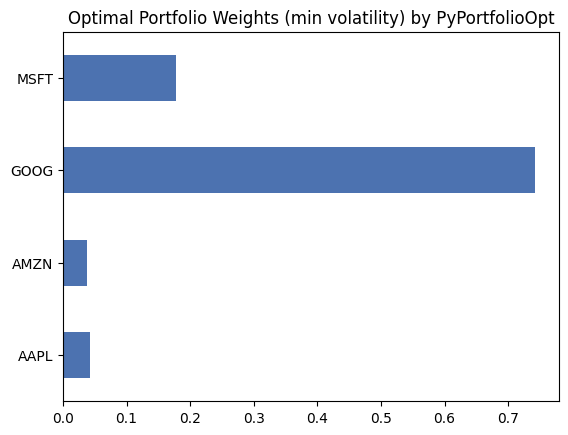

In [17]:
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
import json

mu = expected_returns.capm_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.ema_historical_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.mean_historical_return(df_pivot.set_index('Date'))
print(f'Expected returns from each stock: {mu} \n')

S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()

# Weights between 0 and 1 - we don't allow shorting
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.min_volatility()
weights_min_volatility = ef.clean_weights()

print(f'Portfolio weights for min volatility optimisation (lowest level of risk): {json.dumps(weights_min_volatility, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0124)} \n')
# Risk-free rate : 10Y TBonds rate on 21-Jul-2021 https://www.cnbc.com/quotes/US10Y

pd.Series(weights_min_volatility).plot.barh(title = 'Optimal Portfolio Weights (min volatility) by PyPortfolioOpt');
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef2.max_sharpe()
weights_max_sharpe = ef2.clean_weights()


print(f'Portfolio weights for max Sharpe optimisation (highest return-per-risk): {json.dumps(weights_max_sharpe, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0124)} \n')

In [18]:
expected_returns.np

<module 'numpy' from '/usr/local/lib/python3.10/dist-packages/numpy/__init__.py'>

In [19]:
df_pivot.set_index('Date').iloc[-1]

Ticker
AAPL    173.475006
AMZN    112.600502
GOOG    116.985001
MSFT    309.399994
Name: 2023-05-11, dtype: float64

In [20]:
from pypfopt import DiscreteAllocation

latest_prices = df_pivot.set_index('Date').iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights_max_sharpe, latest_prices, total_portfolio_value = INVESTMENT, short_ratio=0.0)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $79.12 leftover


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 6, 'GOOG': 8, 'MSFT': 1}

In [21]:
for key in alloc.keys():
  print(f' stock: {key}, value = {alloc[key]*latest_prices[key]/INVESTMENT}')

 stock: AMZN, value = 0.3378015060424805
 stock: GOOG, value = 0.46794000244140627
 stock: MSFT, value = 0.15469999694824219


# 3) Manual optimisation: OrderedDict in Python and brute force to generate all possible portfolios 
(discrete values for stocks, no short selling)

In [22]:
from collections import OrderedDict

In [23]:
dict_stocks_prices =  OrderedDict(df_last_day_prices.sort_values(by='Close', ascending=False)['Close'].to_dict())
dict_stocks_prices

OrderedDict([('MSFT', 309.3999938964844),
             ('AAPL', 173.47500610351562),
             ('GOOG', 116.98500061035156),
             ('AMZN', 112.60050201416016)])

In [24]:
for key in dict_stocks_prices.keys():
  print(f' STOCK = {key}, LAST PRICE = {np.round(dict_stocks_prices[key])}, MAX_COUNT = {np.trunc(INVESTMENT/dict_stocks_prices[key])}')

 STOCK = MSFT, LAST PRICE = 309.0, MAX_COUNT = 6.0
 STOCK = AAPL, LAST PRICE = 173.0, MAX_COUNT = 11.0
 STOCK = GOOG, LAST PRICE = 117.0, MAX_COUNT = 17.0
 STOCK = AMZN, LAST PRICE = 113.0, MAX_COUNT = 17.0


In [25]:
copy_dict = dict_stocks_prices.copy() 
copy_dict

OrderedDict([('MSFT', 309.3999938964844),
             ('AAPL', 173.47500610351562),
             ('GOOG', 116.98500061035156),
             ('AMZN', 112.60050201416016)])

In [26]:
def first(s):
    '''Return the first element from an ordered collection
       or an arbitrary element from an unordered collection.
       Raise StopIteration if the collection is empty.
    '''
    return next(iter(s))

In [27]:
item = first(copy_dict)
elem = copy_dict.pop(item)

In [28]:
print(item, elem)
print(copy_dict)
print(dict_stocks_prices)

MSFT 309.3999938964844
OrderedDict([('AAPL', 173.47500610351562), ('GOOG', 116.98500061035156), ('AMZN', 112.60050201416016)])
OrderedDict([('MSFT', 309.3999938964844), ('AAPL', 173.47500610351562), ('GOOG', 116.98500061035156), ('AMZN', 112.60050201416016)])


In [29]:
# Get all options for one-stock investment portfolio (not nessesary spending full sum of money)
def invest_one_stock(investment, dict_stocks_prices):
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)
  print(f'STOCK = {selected_stock}, PRICE = {price}, MAX_TO_BUY = {max_count}')
  
  all_options = []
  print(type(max_count))
  print(list(range(0, max_count+1)) )
  
  for count in range(0, int(max_count)+1):
    result = dict({selected_stock:count})
    print(f'portfolio = {result}, remaining_to_invest = {investment-count*price}')
    all_options.append(result)
  return all_options  

In [30]:
portfolios_one_stock = invest_one_stock(INVESTMENT, dict_stocks_prices.copy())

STOCK = MSFT, PRICE = 309.3999938964844, MAX_TO_BUY = 6
<class 'numpy.int64'>
[0, 1, 2, 3, 4, 5, 6]
portfolio = {'MSFT': 0}, remaining_to_invest = 2000.0
portfolio = {'MSFT': 1}, remaining_to_invest = 1690.6000061035156
portfolio = {'MSFT': 2}, remaining_to_invest = 1381.2000122070312
portfolio = {'MSFT': 3}, remaining_to_invest = 1071.8000183105469
portfolio = {'MSFT': 4}, remaining_to_invest = 762.4000244140625
portfolio = {'MSFT': 5}, remaining_to_invest = 453.0000305175781
portfolio = {'MSFT': 6}, remaining_to_invest = 143.60003662109375


In [31]:
# all options for a partial portfolio investment
portfolios_one_stock

[{'MSFT': 0},
 {'MSFT': 1},
 {'MSFT': 2},
 {'MSFT': 3},
 {'MSFT': 4},
 {'MSFT': 5},
 {'MSFT': 6}]

In [32]:
portfolios_one_stock[0].update({'ANOTHER_STOCK':3})

In [33]:
portfolios_one_stock

[{'MSFT': 0, 'ANOTHER_STOCK': 3},
 {'MSFT': 1},
 {'MSFT': 2},
 {'MSFT': 3},
 {'MSFT': 4},
 {'MSFT': 5},
 {'MSFT': 6}]

In [34]:
def generate_all_portfolios(investment, dict_stocks_prices):
  
  # DEBUG: 
  # print(f'This call: invest_all_stocks({investment}, {dict_stocks_prices})')
  
  # if no stocks to invest ==> return zero portfolio
  if not dict_stocks_prices:
    return []

  # we have at least one stock to invest to ==> try to find min and max investment into that stock
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)

  # print(f'STOCK = {selected_stock}, PRICE = {price}, MAX_TO_BUY = {max_count}, INVESTMENT = {investment}')
  # print(f'   INPUT DICT LEFT AFTER THIS TRANSACTION = {dict_stocks_prices}')
  
  # if can't buy a current stock ==> try to buy a next one (which is a lower price) 
  if max_count ==0:
    return generate_all_portfolios(investment, dict_stocks_prices.copy())

  # if no other stocks left to buy ==> spend all money on the current stock and return 1 option in array: full stock investment
  if len(dict_stocks_prices.keys())==0:
    return [{selected_stock:max_count}]  
  
  all_options = []
  for count in range(0, max_count+1):
    result = dict({selected_stock:count})
    other_portfolios = generate_all_portfolios(investment - count*price, dict_stocks_prices.copy())
    for option in other_portfolios:
      result.update(option)
      all_options.append(dict(result))

  # DEBUG:
  # print(f'all options={all_options}')    
  return all_options  

## 3.3) Generate All portfolios for a given set of stocks and the investment : recursive functio

In [35]:
all_portfolios = generate_all_portfolios(INVESTMENT, dict_stocks_prices.copy())

In [36]:
import random

In [37]:
for elem in all_portfolios[-1]:
  print(f' elem = {elem}, price = {dict_stocks_prices[elem]}')

 elem = MSFT, price = 309.3999938964844
 elem = GOOG, price = 116.98500061035156
 elem = AMZN, price = 112.60050201416016


In [38]:
print(f'Found combinations of portfolios: {len(all_portfolios)}')
for ii in range(1, 6, 1):
    random_portfolio = random.choice(all_portfolios)
    random_portfolio_price = 0
    for elem in random_portfolio:
      random_portfolio_price += random_portfolio[elem] * dict_stocks_prices[elem]
    print(f'Random portfolio {ii}: {random_portfolio} with total price {np.round(random_portfolio_price,1)}')

Found combinations of portfolios: 277
Random portfolio 1: {'MSFT': 1, 'AAPL': 2, 'GOOG': 7, 'AMZN': 4} with total price 1925.6
Random portfolio 2: {'MSFT': 0, 'AAPL': 1, 'GOOG': 4, 'AMZN': 12} with total price 1992.6
Random portfolio 3: {'MSFT': 1, 'AAPL': 7, 'GOOG': 1, 'AMZN': 3} with total price 1978.5
Random portfolio 4: {'MSFT': 4, 'AAPL': 2, 'GOOG': 0, 'AMZN': 3} with total price 1922.4
Random portfolio 5: {'MSFT': 0, 'AAPL': 0, 'GOOG': 9, 'AMZN': 8} with total price 1953.7


## 3.4) Build performance metrics (risk, return, risk/return, CVAr, Max_drawdown) for a given portfolio

In [39]:
SELECTED_PORTFOLIO = {'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1 }

SELECTED_PORTFOLIO

{'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1}

In [40]:
stocks_prices["Date"] = pd.to_datetime(stocks_prices.Date)

In [41]:
one_day = stocks_prices[stocks_prices.Date == '2021-06-08'][['Date','Ticker','Close']].set_index('Date')

In [42]:
one_day

,Ticker,Close
Date,,
2021-06-08,MSFT,248.668320
2021-06-08,AAPL,125.445259
2021-06-08,GOOG,124.142502
2021-06-08,AMZN,163.205505


In [43]:
one_day

,Ticker,Close
Date,,
2021-06-08,MSFT,248.668320
2021-06-08,AAPL,125.445259
2021-06-08,GOOG,124.142502
2021-06-08,AMZN,163.205505


In [44]:
# Mapping quantity for a daily investment
# https://stackoverflow.com/questions/29794959/pandas-add-new-column-to-dataframe-from-dictionary
one_day['qty']= one_day.Ticker.map(SELECTED_PORTFOLIO)

In [45]:
portfolio_value_one_day = np.sum(one_day.Close * one_day.qty)
portfolio_value_one_day

661.4615859985352

In [46]:
all_days = stocks_prices[['Date','Ticker','Close']].set_index('Date')
all_days['qty'] = all_days.Ticker.map(SELECTED_PORTFOLIO)
all_days['price'] = all_days.qty * all_days.Close

In [47]:
portfolio_value_daily = all_days[all_days.index>='2018-01-01'].groupby('Date')['price'].sum()
# daily_investment = pd.pivot_table(all_stocks_portfolio, values='Close', index=['Ticker'], columns=['Close'], aggfunc=np.sum)
portfolio_value_daily

Date
2018-01-02    234.326717
2018-01-03    236.328857
2018-01-04    237.698162
2018-01-05    240.949284
2018-01-08    242.001518
                 ...    
2023-05-05    696.095001
2023-05-08    696.219994
2023-05-09    693.330009
2023-05-10    708.339996
2023-05-11    712.460503
Name: price, Length: 1349, dtype: float64

In [48]:
df_portfolio_value_daily = pd.DataFrame(portfolio_value_daily)

<Axes: title={'center': "Value of a portfolio {'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1} over time"}, xlabel='Date'>

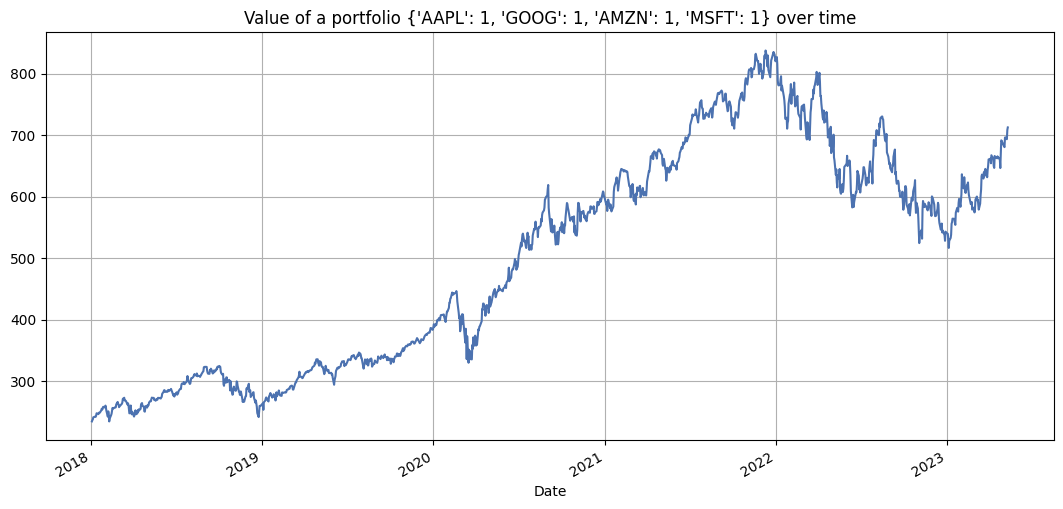

In [49]:
df_portfolio_value_daily.price.plot.line(title=f"Value of a portfolio {SELECTED_PORTFOLIO} over time", grid = True, figsize=(13,6))

In [50]:
# Interactive graph - you can zoom in
fig = px.line(df_portfolio_value_daily, x=df_portfolio_value_daily.index, y="price", title=f'Value of a portfolio {SELECTED_PORTFOLIO} over time -- DYNAMIC')
fig.show()


In [51]:
!pip install portfolio-backtest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
# Insert the directory
# Right click on SwingTrader folder from shared files and select create short cut to add at My Drive
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader')

In [54]:
from portfolio_backtest import Backtest

Backtest(tickers=["MSFT", "AAPL", "GOOG","AMZN"]).run()

[*********************100%***********************]  4 of 4 completed


[{'portfolio': 'Tangency Portfolio',
  'tickers': {'AAPL': 0.81488, 'AMZN': 0.05313, 'GOOG': 0.13199, 'MSFT': 0.0},
  'Expected annual return': '34.6%',
  'Annual volatility': '30.4%',
  'Sharpe Ratio': '1.07',
  'Conditional Value at Risk': '',
  'Cumulative Return': '30079.2%'},
 {'portfolio': 'Minimum Variance Portfolio',
  'tickers': {'AAPL': 0.19653,
   'AMZN': 0.04978,
   'GOOG': 0.25879,
   'MSFT': 0.49491},
  'Expected annual return': '22.7%',
  'Annual volatility': '24.8%',
  'Sharpe Ratio': '0.83',
  'Conditional Value at Risk': '',
  'Cumulative Return': '5727.2%'},
 {'portfolio': 'Hierarchical Risk Parity Portfolio',
  'tickers': {'AAPL': 0.23992,
   'AMZN': 0.17689,
   'GOOG': 0.25722,
   'MSFT': 0.32597},
  'Expected annual return': '26.9%',
  'Annual volatility': '25.4%',
  'Sharpe Ratio': '0.98',
  'Conditional Value at Risk': '',
  'Cumulative Return': '8215.0%'},
 {'portfolio': 'Minimum CVaR Portfolio',
  'tickers': {'AAPL': 0.1933,
   'AMZN': 0.05995,
   'GOOG': 0.25

In [61]:
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

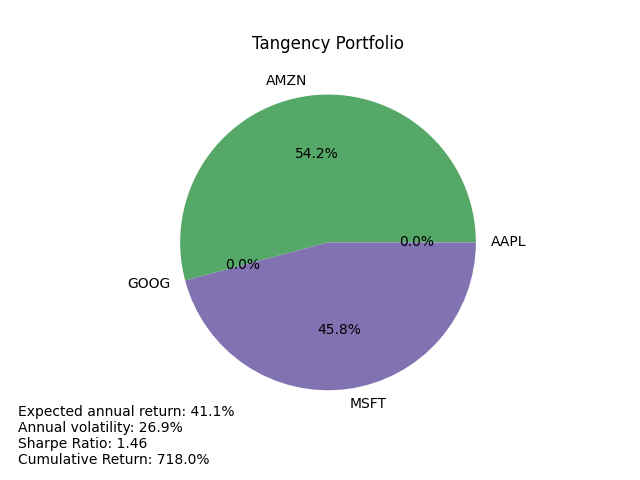

In [64]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/tangency-portfolio.png'))

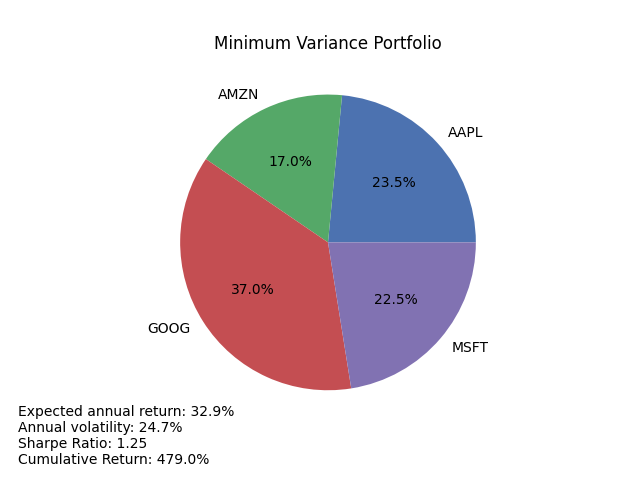

In [66]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/minimum-variance-portfolio.png'))

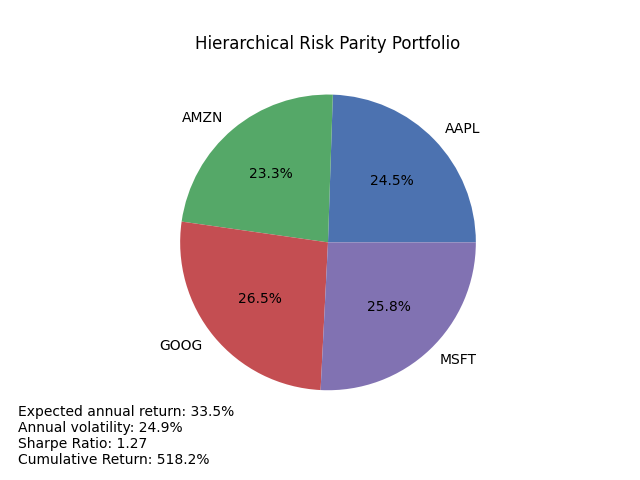

In [67]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/hierarchical-risk-parity-portfolio.png'))

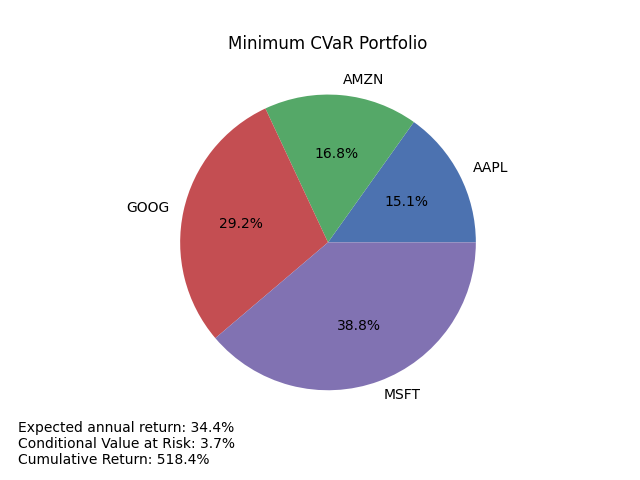

In [68]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/minimum-cvar-portfolio.png'))

## Custom portfolio 

In [55]:
!pip install testfolio -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import testfolio as tsf
#customer weights 
allocation_1 = {
    'AAPL': 0.6,
    'GOOG': 0.2,
    'AMZN': 0.1,
    'MSFT': 0.1
}

backtest_1 = tsf.Backtest(allocation_1, rebalance='q', name='0.6AAPL-0.2GOOG-0.1AMZN-0.1MSFT')
print(backtest_1)

------------------- Metrics -------------------
Name: 0.6AAPL-0.2GOOG-0.1AMZN-0.1MSFT
Allocation: {'AAPL': 0.6, 'GOOG': 0.2, 'AMZN': 0.1, 'MSFT': 0.1}
Starting Value: $1000.00
Ending Value: $205350.19
Start Date: 2004-08-19
End Date: 2023-05-11
CAGR: 32.87%
Maximum Drawdown: -58.81%
STD (annualized): 27.72%
Sharpe Ratio: 1.12
Sortino Ratio: 1.64
Market Correlation: 0.75
-----------------------------------------------



In [57]:
ALIAS_TO_TICKER = {
    'S&P 500': 'VFINX',
    'Long Term Treasury': 'VUSTX',
    'Total US Bond Market': 'VBMFX',
    'Total US Stock Market': 'VTSMX',
    'Total Intl Stock Market': 'VGTSX',
    'Gold': 'GC=F',
    'Intermediate Term Treasury': 'IEF',
    'Short Term Treasury': 'VFISX',
    'REIT': 'VGSIX',
    'US Small Cap': 'NAESX',
    'US Mid Cap': 'VMCIX'
}

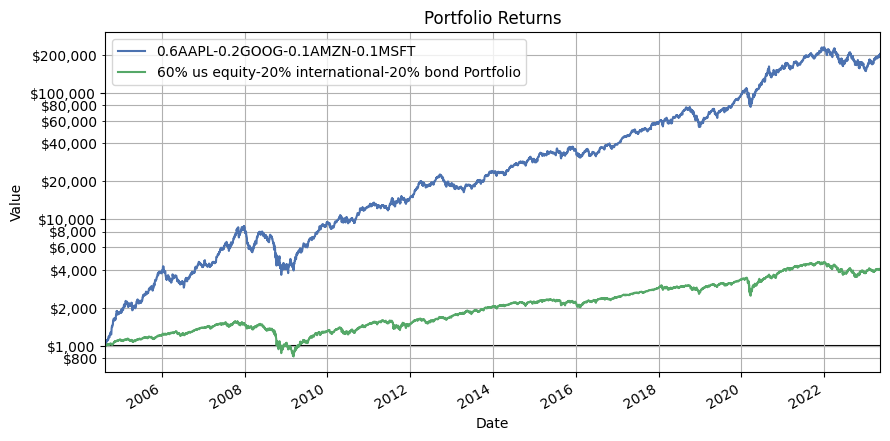

In [58]:
allocation_2 = {
    'Total US Stock Market': 0.60,
    'Total Intl Stock Market': 0.20,
    'Total US Bond Market': 0.20
}

backtest_2 = tsf.Backtest(allocation_2, rebalance='q', name='60% us equity-20% international-20% bond Portfolio')

tsf.graph_return(backtest_1, backtest_2, start_val=1000, logarithmic=True)


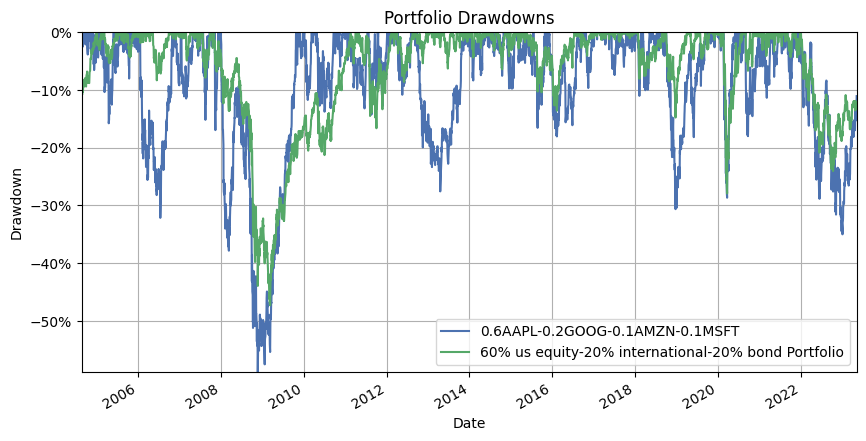

In [59]:
tsf.graph_drawdown(backtest_1, backtest_2)

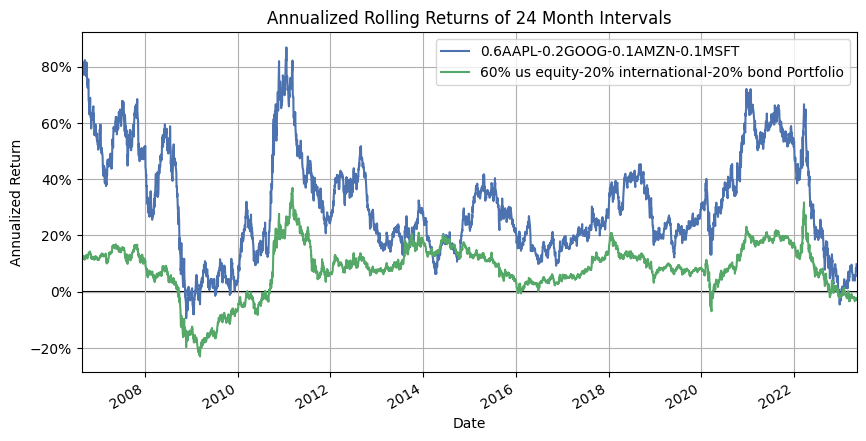

In [60]:
tsf.graph_rolling_returns(backtest_1, backtest_2, interval=24)